# Fitting Parameters
In this notebook, we first recover the model that we have developed and tested for consistency, and engage with it to search the charateristic parameters $\beta, \epsilon, \gamma, \sigma$ for each subject 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import scipy
import scipy.io
np.random.seed()

In [2]:
def modelSimulation(in_con=(0,0,0,0), x_T=1., x_1=.2, sigma=.5, alpha=.5, beta=.5, epsilon=.5, gamma=.5,
                    timestep=1./500, angle=math.pi*7/24, angle0=0, p=(.2,0), r=.1,
                    initial_control=[ 3.04624830e+00, -1.56797070e-01,  5.48092996e-01,  6.52857202e-01, -6.97473103e+00,  6.86269834e-03],
                    Arc=True, Brownian=True):
    
    x,v,y,w = in_con
    
    x_Story=[]
    v_Story=[]
    y_Story=[]
    w_Story=[]
    
    ux_Story=[]
    uy_Story=[]
    
    l=x_T-x
    i=0
    t=0.
    Wt=0.
    lambda2, lambda4, lambda1, lambda3,l1,l3=initial_control
#     ux, uy, lambda1, lambda3,l1,l3=initial_control
    
    while(i<2 or (x<x_T and i<1000)):
            
        t=i*timestep
        
        if(x>x_1):
            lambda1, lambda3=l1,l3
        
        if(Brownian == True):
            W_increment=np.random.normal(0.,np.sqrt(timestep),1)[0]
        else:
            W_increment=1.
            
        Wt=Wt+W_increment
        
        #lambda1=lambda1+timestep*0
        if(i>2 and np.linalg.norm(x-x_T)<timestep*v):
            lambda3=lambda3+timestep*(-2*y)
        
        lambda2=lambda2+timestep*lambda1
        ux=epsilon*l/(1-gamma)*lambda2*math.e**(t/beta)
        lambda4=lambda4+timestep*lambda3
        uy=epsilon*l/(gamma)*lambda3*math.e**(t/beta)
#         ux=ux+timestep*l/(1-gamma)*lambda1
#         uy=uy+timestep*l/(gamma)*lambda3
        
        v=v+timestep*ux
        w=w+timestep*uy
        
        x=x+timestep*v
        y=y+timestep*(w+alpha*ux**2*sigma*W_increment)
        #We record the story
        if(Arc):
            x_Story.append((1+y)*np.cos(angle*(x/x_T-1)+angle0))
            y_Story.append((1+y)*np.sin(angle*(x/x_T-1)+angle0))
        else:
            x_Story.append(x)
            y_Story.append(y)
        v_Story.append(v)
        w_Story.append(w)
        ux_Story.append(ux)
        uy_Story.append(uy)
        
        i=i+1
    if(i==1000):
        t=1000
    return np.array(x_Story), np.array(v_Story), np.array(ux_Story),\
            np.array(y_Story), np.array(w_Story), np.array(uy_Story), t

# Data Cleaning

The follwing cells are dedicated to reading the data of the subjects, select trials that fulfill the trial conditions, and are therefore not considered failed, and leave the remaining information to be processed later.

In [3]:
class rectangle:
    
    def __init__(self, points):
        self.points=np.array(points)
        if(points.shape!=(4,2)):
            print("No!")
            return None
        self._vect1=self.points[1]-self.points[0]
        self._vect2=self.points[3]-self.points[0]
        self._mod1=np.linalg.norm(self._vect1)
        self._mod2=np.linalg.norm(self._vect2)
        self._nvect1=self._vect1/self._mod1
        self._nvect2=self._vect2/self._mod2
        dot=np.dot(self._nvect1,self._nvect2)
        self.angle=math.degrees(math.acos(dot))
        
    def point_in_rectangle(self, point):
        point=np.array(point)
        if(point.shape!=(2,)):
            return False
        vector=point-self.points[0]
        dot1=np.dot(self._nvect1,vector)
        dot2=np.dot(self._nvect2,vector)
        if(dot1<0 or dot2<0):
            return False
        if(dot1<self._mod1 and dot2<self._mod2):
            return True
        return False

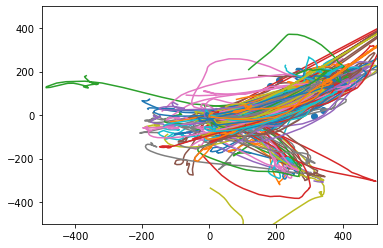

Wall time: 722 ms


In [4]:
%%time

# del mat,dfx,dfy

rectx,recty=np.array([314, 341, 210, 183]), np.array([-2,  24, 161, 135])
trials = (1,2,4,5,6,26)

subjectn=12
n=str(subjectn)

mat = scipy.io.loadmat('../subjectData/Subject'+n+'/Subject-'+n+'-Trajectories-'+str(trials[0])+'.mat')
dfx = pd.DataFrame(mat["X1"].T)
dfy = pd.DataFrame(mat["Y1"].T)
for i in range(1,len(trials)):
    mat = scipy.io.loadmat('../subjectData/Subject'+n+'/Subject-'+n+'-Trajectories-'+str(trials[i])+'.mat')
    dfx = dfx.append(pd.DataFrame(mat["X1"].T))
    dfy = dfy.append(pd.DataFrame(mat["Y1"].T))
    
dfx=dfx.reset_index().drop(columns="index")
dfy=dfy.reset_index().drop(columns="index")

for i, row in dfx.iterrows():
    plt.plot(dfx.loc[i],dfy.loc[i])

plt.xlim([-500, 500])
plt.ylim([-500, 500])
plt.scatter(rectx,recty)
plt.show()

In [5]:
rectx,recty=np.array([314, 341, 210, 183]), np.array([-2,  24, 161, 135])
rect=rectangle(np.vstack((rectx,recty)).T)

dfx1=dfx-rect.points[0][0]
dfy1=dfy-rect.points[0][1]
dfdot1=rect._nvect1[0]*dfx1+rect._nvect1[1]*dfy1
dfdot2=rect._nvect2[0]*dfx1+rect._nvect2[1]*dfy1
dfbool1=(dfdot1>0) & (dfdot1<rect._mod1)
dfbool2=(dfdot2>0) & (dfdot2<rect._mod2)
dfbool=dfbool1 & dfbool2
idxrule=dfbool.T.idxmax()

In [6]:
%%time
for i, row in dfx.iterrows():
    dfx.loc[i, idxrule[i]:]=np.nan
    dfy.loc[i, idxrule[i]:]=np.nan

Wall time: 103 ms


In [7]:
%%time
index1=dfy[(dfy > 500).any(1)].index
index2=dfx[(dfx > 300).any(1)].index
index=index1.union(index2)
dfx=dfx.drop(index=index)
dfy=dfy.drop(index=index)

Wall time: 29.9 ms


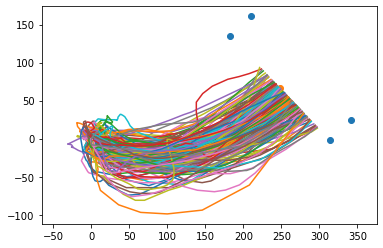

In [8]:
for i, row in dfx.iterrows():
    plt.plot(dfx.loc[i],dfy.loc[i])

plt.axis('equal')
plt.scatter(rectx,recty)
plt.scatter((rectx[3]+rectx[0])/2,(recty[3]+recty[0])/2)
plt.show()

In [9]:
dfx1=dfx.iloc[:,1:]
dfx1.columns = range(dfx1.shape[1])
dfvx=dfx1-dfx.iloc[:,:-1]

dfy1=dfy.iloc[:,1:]
dfy1.columns = range(dfy1.shape[1])
dfvy=dfy1-dfy.iloc[:,:-1]

dfv=np.sqrt(np.square(dfvx)+np.square(dfvy))

# Linear transformation
We scale and rotate the data using a linear transformation to align the Experimental Data with Model data: Finish line at $y=0$ and trajectory following a unit circle

In [10]:
model_target = np.array((1,0))
screen_target = np.array(((rectx[3]+rectx[0])/2,(recty[3]+recty[0])/2))
model_origin = np.array((np.cos(-math.pi*7/24),np.sin(-math.pi*7/24)))
screen_origin = np.array((0,0))

d_model=np.linalg.norm(model_target-model_origin)
d_screen=np.linalg.norm(screen_target-screen_origin)

v_model=model_target-model_origin
v_model_ort=np.array((v_model[1],-v_model[0]))

v_screen=screen_target-screen_origin
v_screen_ort=np.array((v_screen[1],-v_screen[0]))

model_M=np.vstack((np.append(model_origin,1),np.append(model_target,1),np.append(v_model_ort,0))).T
screen_M=np.vstack((np.append(screen_origin,1),np.append(screen_target,1),np.append(v_screen_ort,0))).T

M=np.dot(model_M,np.linalg.inv(screen_M))
A=M[:2,:2]
b=M[:2,-1:].flatten()

In [11]:
dfx1=A[0,0]*dfx+A[0,1]*dfy+b[0]
dfy1=A[1,0]*dfx+A[1,1]*dfy+b[1]
dfx=dfx1
dfy=dfy1

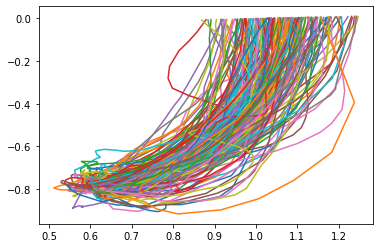

In [12]:
for i in range(len(dfx)):
    plt.plot(dfx.iloc[i],dfy.iloc[i])
plt.show()

In [13]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis

for i in range(len(dfx)):
    ax.plot(dfx.iloc[i],dfy.iloc[i])

fig.savefig('../img/OptitrackRecordings.png', bbox_inches='tight')   # save the figure to file
plt.close(fig)  

# Mean path

We obtain the estimators (T,vel) of the dataset, and use them as optimisation targets, to obtain $\beta, \epsilon, \gamma$.

In [14]:
desx=dfx.describe()
desy=dfy.describe()
xmean=desx.iloc[1]
ymean=desy.iloc[1]
xstd=desx.iloc[2]
ystd=desy.iloc[2]

In [15]:
T=idxrule.mean()/1000
vel=dfv.T.max().mean()
T,vel

(0.8236980198019802, 1.443888658332092)

In [17]:
T=idxrule.mean()/1000
vel=dfv.T.max().mean()
def fun3 (parameters):
    beta, epsilon, gamma= parameters
    
    x2,v2,ux2,y2,w2,uy2,T2=modelSimulation(sigma=0, beta=beta, epsilon=epsilon, gamma=gamma)
    vel2=np.max(np.sqrt(np.square(v2)+np.square(w2)))
    return (T2-T)**2+(vel2-vel)**2

res3=scipy.optimize.minimize(fun3, (.5, .5, .5), args=(), method=None)
res3.x, fun3(res3.x), (T,vel)

(array([0.50601148, 0.09003115, 0.60013745]),
 0.18170625011913877,
 (0.8236980198019802, 1.443888658332092))

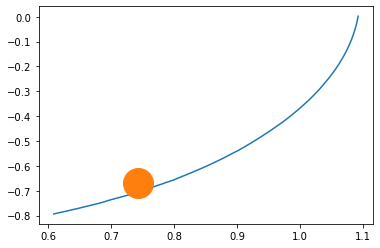

In [18]:
beta, epsilon, gamma = res3.x
x,v,ux,y,w,uy,T=modelSimulation(beta=beta, epsilon=epsilon, gamma=gamma)
plt.plot(x,y)
angle=math.pi*7/24
T_1=.2
plt.plot(np.cos(angle*(T_1-1)),np.sin(angle*(T_1-1)),marker='o',markersize=30)
plt.show()

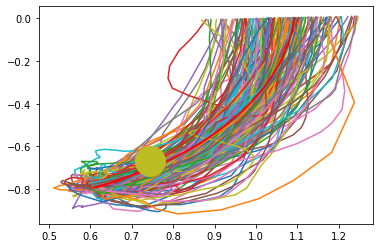

In [19]:
%matplotlib inline

beta, epsilon, gamma = res3.x
x,v,ux,y,w,uy,T=modelSimulation(sigma=0, beta=beta, epsilon=epsilon, gamma=gamma)
# x2=xmean
# y2=ymean

for i in range(len(dfx)):
    plt.plot(dfx.iloc[i],dfy.iloc[i])
    
plt.plot(x,y,'r',linewidth=2)
# plt.plot(x2-2*xstd,y2+2*ystd,'r',linewidth=2)
# plt.plot(x2+2*xstd,y2-2*ystd,'r',linewidth=2)
T_1=.2
plt.plot(np.cos(angle*(T_1-1)),np.sin(angle*(T_1-1)),marker='o',markersize=30)
plt.show()

# Deviation of the mean path

Here, we obtain the set of estimators xT_samples, wich will be used in the Kolmogorov-Smirnov Test to find the optimal $sigma$

In [20]:
from scipy.stats import ks_2samp 

In [21]:
xT_samples=[]

for i, row in dfx.iterrows():
    if (idxrule[i]>0):
        xT_samples.append(dfx.loc[i][idxrule[i]-1])

In [31]:
beta, epsilon, gamma = res3.x
T_samples=idxrule
vel_samples=dfv.T.max()

# Kolmogorov Smirnov Test

def fun4 (parameters):
    sigma = parameters
    
    xT2_samples=[]

    for i in range(50):
        x2,v2,ux2,y2,w2,uy2,T2=modelSimulation(sigma=sigma, beta=beta, epsilon=epsilon, gamma=gamma)
        xT2_samples.append(x2.flatten()[-1])
    
    return ks_2samp(xT_samples, xT2_samples)[0]

res4=scipy.optimize.minimize_scalar(fun4, bracket=None, bounds=None, args=(), method='golden', tol=None, options=None)
res4.x, fun4(res4.x)

(26.051173415099957, 0.18)

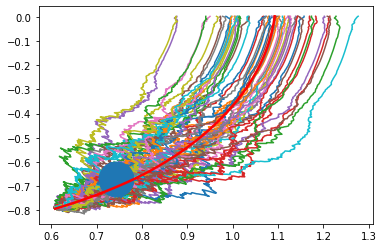

In [105]:
beta, epsilon, gamma = res3.x
sigma = res4.x
    
xT2_samples=[]

fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis


for i in range(50):
    x2,v2,ux2,y2,w2,uy2,T2=modelSimulation(sigma=sigma, beta=beta, epsilon=epsilon, gamma=gamma)
    xT2_samples.append(x2.flatten()[-1])
    plt.plot(x2,y2)

plt.plot(np.cos(angle*(T_1-1)),np.sin(angle*(T_1-1)),marker='o',markersize=35)

x2,v2,ux2,y2,w2,uy2,T2=modelSimulation(sigma=0, beta=beta, epsilon=epsilon, gamma=gamma)
plt.plot(x2,y2,'r',linewidth=2.5)

# fig.savefig('../img/Model.png', bbox_inches='tight')   # save the figure to file
# plt.close(fig) 

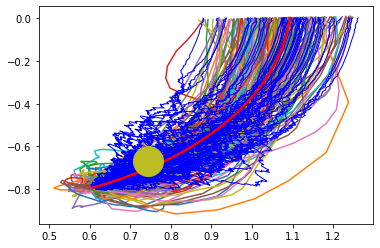

In [96]:
%matplotlib inline

beta, epsilon, gamma = res3.x
sigma = res4.x

for i in range(len(dfx)):
    plt.plot(dfx.iloc[i],dfy.iloc[i])
    
for i in range(50):
    x2,v2,ux2,y2,w2,uy2,T2=modelSimulation(sigma=sigma, beta=beta, epsilon=epsilon, gamma=gamma)
    plt.plot(x2,y2,'b',linewidth=1)
    
x2,v2,ux2,y2,w2,uy2,T2=modelSimulation(sigma=0, beta=beta, epsilon=epsilon, gamma=gamma)
plt.plot(x2,y2,'r',linewidth=2)

angle=math.pi*7/24
T_1=.2
plt.plot(np.cos(angle*(T_1-1)),np.sin(angle*(T_1-1)),marker='o',markersize=30)
plt.show()

In [36]:
parameters12=np.append(res3.x,res4.x)
parameters12

array([ 0.50601148,  0.09003115,  0.60013745, 26.05117342])

# Parameters overview

We store the parameters obtained for each subject, and, then produce a graphic with the results.

In [87]:
parameters= np.array([[ 0.53860215,  0.0912296 ,  0.5506773 , 30.85398832],
       [ 0.50667106,  0.08315916,  0.60534727, 24.3977411 ],
       [ 0.58233163,  0.09243736,  0.58636269, 33.45446272],
       [ 0.49434813,  0.07986471,  0.55464631, 25.51013515],
       [ 0.51113938,  0.0805632 ,  0.56045806, 24.99960123],
       [ 0.46736579,  0.09260314,  0.58710506, 34.72651353],
       [ 0.44629047,  0.08681463,  0.59958521, 32.87872482],
       [ 0.47009312,  0.09198422,  0.64090731, 40.10251655],
       [ 0.51960109,  0.0837997 ,  0.63226561, 24.3314153 ],
       [ 0.46426725,  0.08427709,  0.61949113, 21.89446593],
       [ 0.50601148,  0.09003115,  0.60013745, 26.05117342]])

In [89]:
parameters/np.array((1,1,1,40))

array([[0.53860215, 0.0912296 , 0.5506773 , 0.77134971],
       [0.50667106, 0.08315916, 0.60534727, 0.60994353],
       [0.58233163, 0.09243736, 0.58636269, 0.83636157],
       [0.49434813, 0.07986471, 0.55464631, 0.63775338],
       [0.51113938, 0.0805632 , 0.56045806, 0.62499003],
       [0.46736579, 0.09260314, 0.58710506, 0.86816284],
       [0.44629047, 0.08681463, 0.59958521, 0.82196812],
       [0.47009312, 0.09198422, 0.64090731, 1.00256291],
       [0.51960109, 0.0837997 , 0.63226561, 0.60828538],
       [0.46426725, 0.08427709, 0.61949113, 0.54736165],
       [0.50601148, 0.09003115, 0.60013745, 0.65127934]])

Text(0, 0.5, 'height')

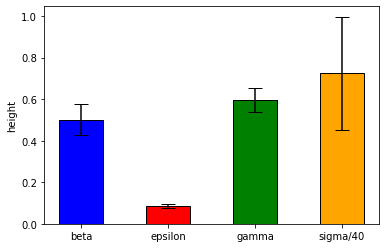

In [104]:
# width of the bars
barWidth = 0.5
 
# Choose the height of the blue bars
bars1 = parameters.mean(axis=0)/np.array((1,1,1,40))
 
# Choose the height of the error bars (bars1)
yer1 = 2*parameters.std(axis=0)/np.array((1,1,1,40))
 
# The x position of bars
r1 = np.arange(len(bars1))

fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
 
# Create blue bars
ax.bar(r1, bars1, width = barWidth, color = ['blue','red','green','orange'], edgecolor = 'black', yerr=yer1, capsize=7,)
 
# general layout
plt.xticks(r1, ['beta', 'epsilon', 'gamma', 'sigma/40'])
plt.ylabel('height')
 
# Save graphic

# fig.savefig('../img/Parameters.png', bbox_inches='tight')   # save the figure to file
# plt.close(fig) 